# Aztec G-dDT Test Run

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import os
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "png"

## Perform Simulation

In [2]:
from aztec_gddt.scenario_experiments import scenario_group_1_experiment

N_TIMESTEPS = 300
N_SAMPLES = 1
N_CONFIG_SAMPLES = 8
RELEVANT_PER_TRAJECTORY_METRICS = ['T-M1', 'T-M2', 'T-M3']
RELEVANT_PER_TRAJECTORY_GROUP_METRICS = ['TG-M1', 'TG-M2', 'TG-M3']

CONTROL_PARAMS = [
        'RELATIVE_TARGET_MANA_PER_BLOCK',
        'MAXIMUM_MANA_PER_BLOCK',
        'MINIMUM_MULTIPLIER_CONGESTION',
        'RELATIVE_UPDATE_FRACTION_CONGESTION',
        'OVERHEAD_MANA_PER_TX',
        'MAXIMUM_UPDATE_PERCENTAGE_C',
        ]


In [3]:
from aztec_gddt.analysis.execute import execute_sim, complexity_desc
sim_df, exec_time = execute_sim(scenario_group_1_experiment,
                                 N_TIMESTEPS=N_TIMESTEPS,
                                   N_SAMPLES=N_SAMPLES,
                                     N_CONFIG_SAMPLES=N_CONFIG_SAMPLES)

print(complexity_desc(sim_df, exec_time))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (2, 600, 78, 8, 32)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (300, 39, 5, 32)
     Simulation 1: (Timesteps, Params, Runs, Sub-States) = (300, 39, 3, 32)


Initializing configurations:   0%|          | 0/8 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/16808 [00:00<?, ?it/s]

Total execution time: 1.01s

    #### Computational Complexity:
    1. Total number of parameter combinations: 8
    2. Total number of Monte Carlo runs per parameter combination: 8
    3. Total number of trajectories: 8
    4. Total number of timesteps per trajectory: 300
    5. Total number of state measurements: 2,408
    6. Workflow execution time: 1.65 seconds (0.206 seconds per trajectory)
    7. Engine execution time: 1.01 seconds (0.127 seconds per trajectory)
    


## Visualization over Model Features

## Visualization over PSUU Per-Trajectory Metrics

### Protocol Parameter Recommendations 


| Control Parameter | Recommended Range | Unit |
| - | - | - |
| RELATIVE_TARGET_MANA_PER_BLOCK | tbd | Mana |
| MAXIMUM_MANA_PER_BLOCK | tbd | Mana |
| MINIMUM_MULTIPLIER_CONGESTION | tbd | Unitless |
| UPDATE_FRACTION_CONGESTION | tbd | 1 / Mana |
| OVERHEAD_MANA_PER_TX | tbd | Mana |
| PROVING_COST_MODIFIER_INITIAL_C | tbd | Mana |
| FEE_JUICE_PRICE_MODIFIER_INITIAL_C | tbd | Juice per Wei |
| MAXIMUM_UPDATE_PERCENTAGE_C | tbd | Unitless |

### Decision Tree and Parameter Importance

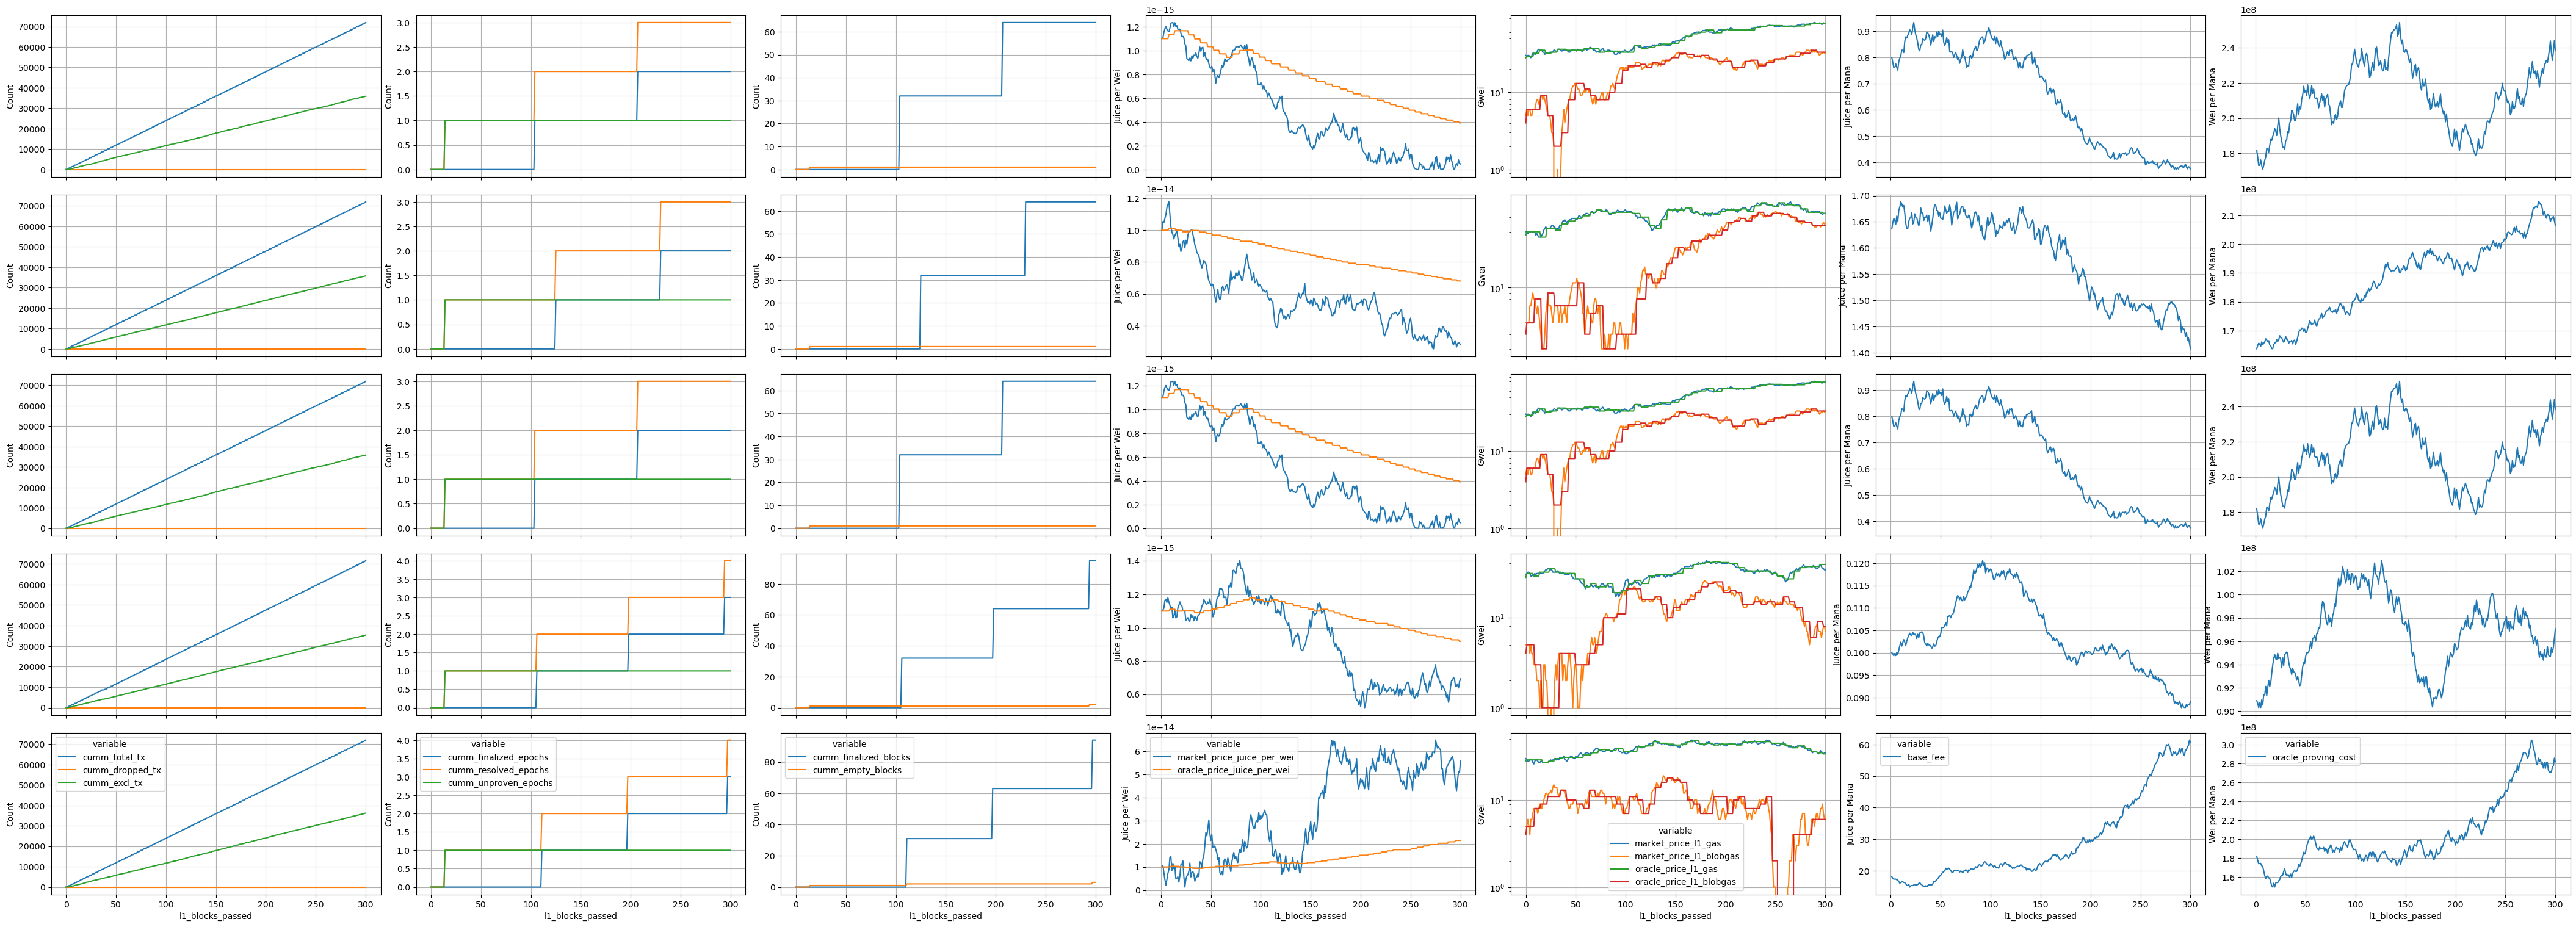

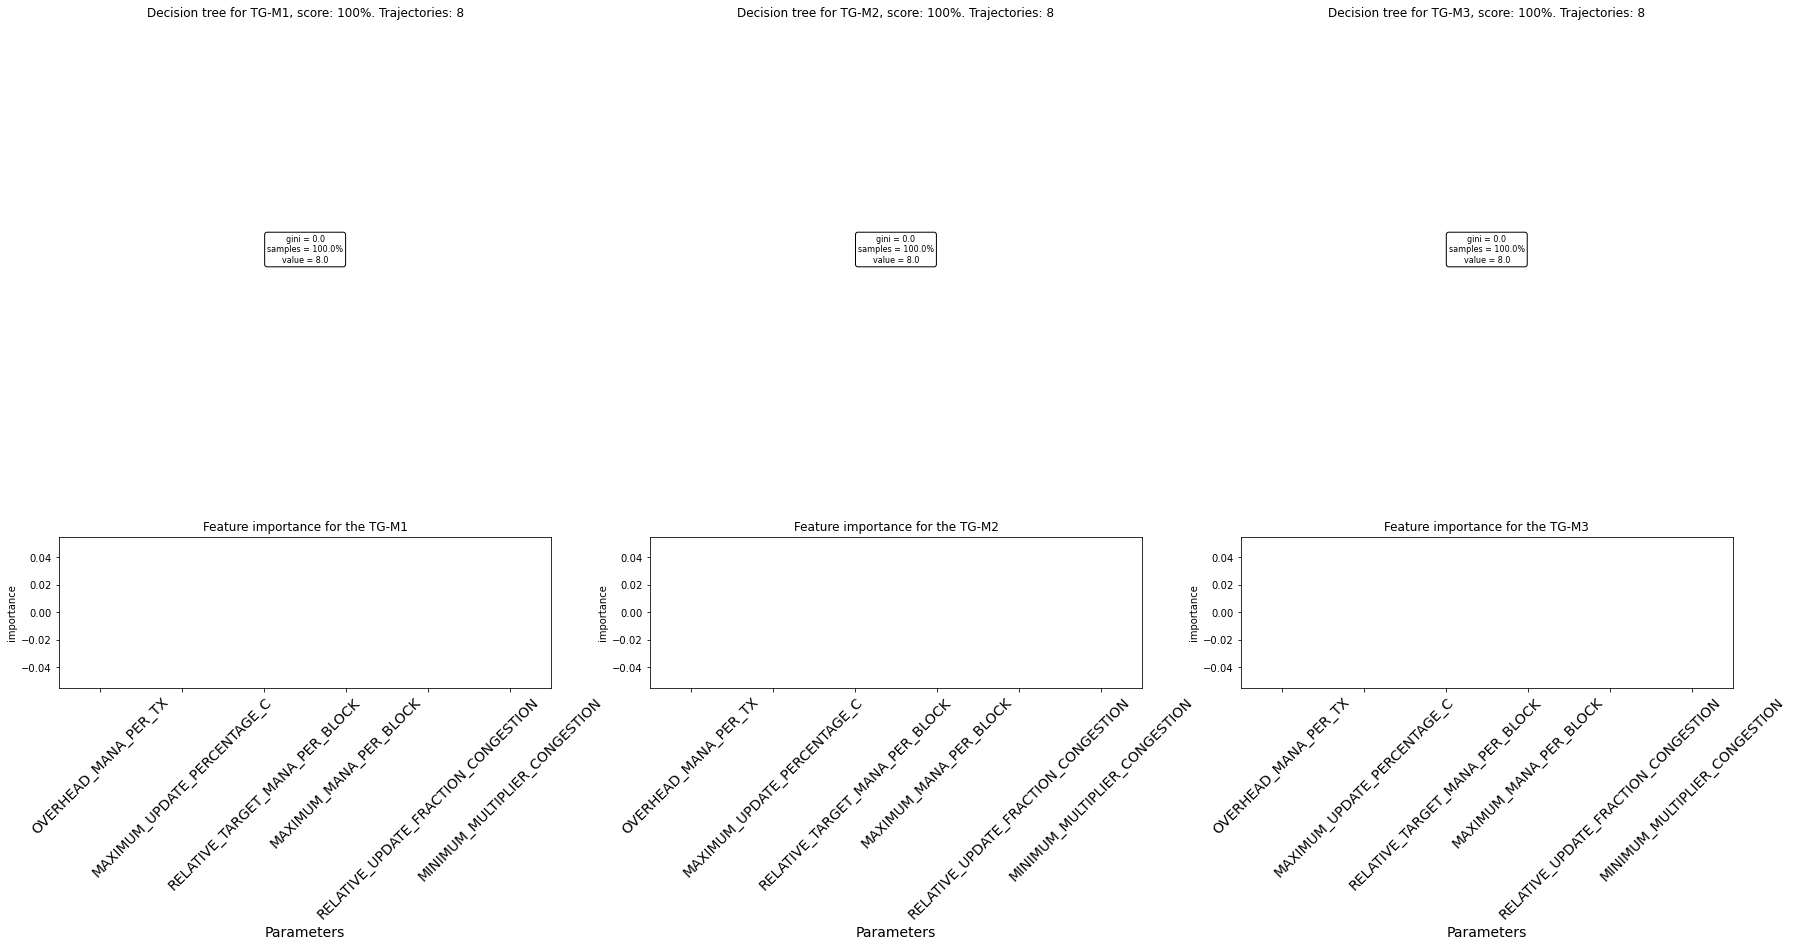

In [4]:
from aztec_gddt.analysis.metrics import *
from aztec_gddt.analysis.visualizations import plot_agg_kpis, plot_inspect_vars

agg_df, c_agg_df = retrieve_feature_df(sim_df, CONTROL_PARAMS, RELEVANT_PER_TRAJECTORY_GROUP_METRICS)
plot_inspect_vars(sim_df)
plot_agg_kpis(agg_df, CONTROL_PARAMS, RELEVANT_PER_TRAJECTORY_GROUP_METRICS)

### Commentary on Results:
